In [16]:
pip install -U classiq

  Obtaining dependency information for classiq from https://files.pythonhosted.org/packages/c4/19/3304f0edaec0f04a47f5628ca79acb5b4dd7a66845c47df9b970926ff90a/classiq-0.33.0-py3-none-any.whl.metadata
  Using cached classiq-0.33.0-py3-none-any.whl.metadata (3.0 kB)
Using cached classiq-0.33.0-py3-none-any.whl (358 kB)
  Attempting uninstall: classiq
    Found existing installation: classiq 0.32.0
    Uninstalling classiq-0.32.0:
      Successfully uninstalled classiq-0.32.0
Note: you may need to restart the kernel to use updated packages.


In [33]:
#Finance Model

#importing necessary modules 

import classiq
from classiq.builtin_functions import PiecewiseLinearAmplitudeLoading, PhaseEstimation
from classiq import QUInt, Model, synthesize, show, QReg, ControlState, execute
from classiq import FunctionGenerator, FunctionLibrary, RegisterUserInput
from classiq.builtin_functions import LinearPauliRotations, StatePreparation
from classiq.builtin_functions import XGate, UGate, ZGate
from classiq.model import Constraints
from classiq.execution import ExecutionDetails
import numpy as np
import matplotlib.pyplot as plt

In [34]:
#state preparation block 

sp_num_qubits = 3

qmci_library = FunctionLibrary()
function_generator =  FunctionGenerator(function_name="state_loading")


input_dict = function_generator.create_inputs({"io": QUInt[sp_num_qubits], "ind": QUInt[1]})
probabilities = np.linspace(0, 1, 2**sp_num_qubits) / sum(
    np.linspace(0, 1, 2**sp_num_qubits))

#can be specified, this is just an example
#for a better code, I will make the probabilities list a user input 
#and give options of usual distributions like Gaussian, log-normal etc

print(probabilities)

sp_params = StatePreparation(
    probabilities=probabilities, error_metric={"KL": {"upper_bound": 0.00}}
)

sp_output = function_generator.StatePreparation(
    params=sp_params, strict_zero_ios=False, in_wires={"IN": input_dict["io"]})

# print(sp_output)

function_generator.set_outputs({"io": sp_output["OUT"], "ind": input_dict["ind"]})
qmci_library.add_function(function_generator.to_function_definition())


[0.         0.03571429 0.07142857 0.10714286 0.14285714 0.17857143
 0.21428571 0.25      ]


In [36]:
#Amplitude Loading block

function_generator = FunctionGenerator(function_name="amp_load")

input_dict = function_generator.create_inputs(
    {"io": QUInt[sp_num_qubits], "ind": QUInt[1]}
)

amplitude_loading_params = PiecewiseLinearAmplitudeLoading(
    num_qubits=3,
    breakpoints=[0.5, 3.14, 5],
    affine_maps=[{"offset": 0, "slope": 0}, {"offset": -3.14, "slope": 1}],
    rescaling_factor=0.001)

#breakpoints=[s0 * Y[0], k, s0 * Y[-1]]

al_output = function_generator.PiecewiseLinearAmplitudeLoading(
    params=amplitude_loading_params, strict_zero_ios=False, in_wires={"state":input_dict["io"], "target": input_dict["ind"]}
)
print(al_output)
# scaled_expectation_value = 0.7  # Probability of 1 after some execution
# expectation_value = amplitude_loading_params.compute_expectation_value(
#     scaled_expectation_value
# )
function_generator.set_outputs({"io": al_output["state"], "ind": al_output["target"]})
qmci_library.add_function(function_generator.to_function_definition())

{'state': <classiq.quantum_register.QUInt object at 0x00000235ECD39D90>, 'target': <classiq.quantum_register.QUInt object at 0x00000235EDF6BC50>}


In [37]:
#Expected Outcome

sp_num_qubits= 3
probabilities = np.linspace(0, 1, 2**sp_num_qubits) / sum(
    np.linspace(0, 1, 2**sp_num_qubits)
)
k=3.14
s0= 5
Y= [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 1]
expected_expectation_value = sum(
    [probabilities[x] * max(s0 * Y[x] - k, 0) for x in range(len(probabilities))]
)
print('EXPECTED PAYOFF:', expected_expectation_value)

EXPECTED PAYOFF: 0.5421428571428573


In [38]:
#Good state Oracle

function_generator = FunctionGenerator(function_name="good_state_oracle")

input_dict = function_generator.create_inputs(
    {"io": QUInt[sp_num_qubits], "ind": QUInt[1]}
)

z_out = function_generator.ZGate(
    params=ZGate(),
    in_wires={"TARGET": input_dict["ind"]},
)

function_generator.set_outputs({"ind": z_out["TARGET"], "io": input_dict["io"]})
qmci_library.add_function(function_generator.to_function_definition())

In [39]:
#Function representing reflection about the zero state

function_generator = FunctionGenerator(function_name="zero_oracle")

reg_size = sp_num_qubits + 1
input_dict = function_generator.create_inputs({"mcz_io": QUInt[reg_size]})

x_out = function_generator.XGate(
    params=XGate(),
    in_wires={"TARGET": input_dict["mcz_io"][0]},
    should_control=False,
)

control_states = ControlState(ctrl_state="0" * (reg_size - 1), name="ctrl_reg")

mcz_out = function_generator.ZGate(
    params=ZGate(),
    control_states=control_states,
    in_wires={"TARGET": x_out["TARGET"], "ctrl_reg": input_dict["mcz_io"][1:reg_size]},
)

x_out = function_generator.XGate(
    params=XGate(), in_wires={"TARGET": mcz_out["TARGET"]}, should_control=False
)

function_generator.set_outputs(
    {"mcz_io": QReg.concat(x_out["TARGET"], mcz_out["ctrl_reg"])}
)

qmci_library.add_function(function_generator.to_function_definition())

In [40]:
## composite for Grover Diffuser

function_generator = FunctionGenerator(function_name="grover")
function_generator.include_library(qmci_library)


in_wires = function_generator.create_inputs(
    {"io": QUInt[sp_num_qubits], "ind": QUInt[1]}
)

oracle_out = function_generator.good_state_oracle(in_wires=in_wires)

pay_off_load_inv= function_generator.amp_load(in_wires={"io": oracle_out["io"], "ind": oracle_out["ind"]})

sps_inverse_out = function_generator.state_loading(
    in_wires={"io": pay_off_load_inv["io"], "ind": pay_off_load_inv["ind"]},
    is_inverse=True,
    should_control=False,
)

zero_oracle_out = function_generator.zero_oracle(
    in_wires={"mcz_io": QReg.concat(sps_inverse_out["io"], sps_inverse_out["ind"])}
)

sps_out = function_generator.state_loading(
    in_wires={
        "io": zero_oracle_out["mcz_io"][0:sp_num_qubits],
        "ind": zero_oracle_out["mcz_io"][sp_num_qubits],
    },
    should_control=False,
)

pay_off_load= function_generator.amp_load(in_wires={"io": sps_out["io"], "ind": sps_out["ind"]})

global_phase_out = function_generator.UGate(
    UGate(theta=0, phi=0, lam=0, gam=np.pi), in_wires={"TARGET": pay_off_load["ind"]}
)

function_generator.set_outputs({"io": pay_off_load["io"], "ind": global_phase_out["TARGET"]})

qmci_library.add_function(function_generator.to_function_definition())

In [43]:
#APPLYING AMPLITUDE ESTIMATION (AE) WITH QUANTUM PHASE ESTIMATION (QPE)

n_qpe = 2
model = Model()
model.include_library(qmci_library)
sp_output = model.state_loading()
al_output= model.amp_load(in_wires={"io": sp_output["io"], "ind": sp_output["ind"]})

qpe_out = model.PhaseEstimation(
    params=PhaseEstimation(
        size=n_qpe, unitary_params=qmci_library.get_function("grover"), unitary="grover"
    ),
    in_wires={"io": al_output["io"], "ind": al_output["ind"]},
)

model.set_outputs({"phase_result": qpe_out["PHASE_ESTIMATION"]})
qprog = synthesize(model.get_model())
show(qprog)

Opening: https://platform.classiq.io/circuit/27cdb38e-4650-48bc-8da4-b18f560f52d9?version=0.32.1


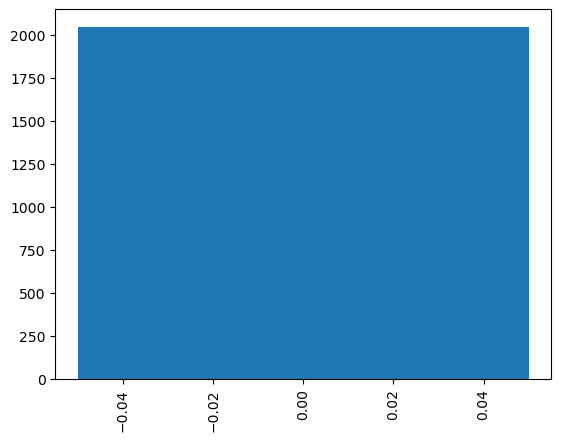

phase with max probability:  0.0
measured amplitude/PAYOFF:  0.0


In [44]:
results = execute(qprog).result()

from classiq.execution import ExecutionDetails

res = results[0].value

phases_counts = res.parsed_counts

## mapping between register string to phases
phases_counts = dict(
    (sampled_state.state["phase_result"] / 2**n_qpe, sampled_state.shots)
    for sampled_state in res.parsed_counts
)

plt.bar(phases_counts.keys(), phases_counts.values(), width=0.1)
plt.xticks(rotation=90)
plt.show()
print("phase with max probability: ", max(phases_counts, key=phases_counts.get))

print(
    "measured amplitude/PAYOFF: ",
    np.sin(np.pi * max(phases_counts, key=phases_counts.get)) ** 2,
)